# Read and process groundwater data ILVO agricultural park

Load essential Python modules

In [1]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from pandasql import sqldf
import datetime
#!pip install traces

In [ ]:
def get_diff(x,y):
    pysqldf = lambda q: sqldf(q, globals())
    p="select abs(x.Pressure-y.Pressure) as diff, x.Date from x,y where x.Date==y.Date"
    return pysqldf(p)

## Read raw data from excell files and plot for quick inspection

### Read data

In [2]:
path = os.getcwd()
os.chdir('raw_data')
datapath = os.getcwd()
baro_ind='AP825'
xls_files = glob.glob(os.path.join(datapath, "*.xlsx"))
    
#loop over the list of xls files
ind = 0
diver_names={}
alldf={}
for i,f in enumerate(xls_files):
    # read the csv file
    df = pd.read_excel(f)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    # print the location and filename for check
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])
    df=df.assign(Date=df.TimeStamp.dt.round('H'))
    df['Date']=pd.to_datetime(df['Date'])
    dfdaily=df.resample('D', on = 'Date').mean()

    # merge all data in 1 dataframe
    if baro_ind in f:
        baro_data=df
        #baro_data=baro_data.append.df# this tests for substrings
    if ind == 0:
        #First data frame loaded
        GWdata = df
        GWdata_daily = dfdaily
    else:
        # Paste the rest to this dataframe
        GWdata = GWdata.append(df, ignore_index=True)
        GWdata_daily = GWdata_daily.append(df, ignore_index=True)
        alldf[i]=df
    

    ind = ind + 1 
#Remove empty columns from the dataframe    
GWdata.drop(labels=['Conductivity', 'WaterLevel','WaterLevelReference'], axis=1)

# Read manually measured water dephts for inspection of the data    
os.chdir('info')
df_info = pd.read_excel('manual_check_water_depth.xlsx')
    


Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701135826_AP825.xlsx
File Name: ILVO_210701135826_AP825.xlsx
Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140247_AP707.xlsx
File Name: ILVO_210701140247_AP707.xlsx
Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140912_AZ649.xlsx
File Name: ILVO_210701140912_AZ649.xlsx
Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141446_AG083.xlsx
File Name: ILVO_210701141446_AG083.xlsx
Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141936_CA186.xlsx
File Name: ILVO_210701141936_CA186.xlsx
Location: C:\Users\amehmandoostkotlar\OneDrive - ILVO\GitHub\onderzoekskouter_water\groundwater\raw_data\ILVO_210701142455_CA969.x

rem6-2
AP707 - AG083 / 183.7
rem5-2
CA969 - AG083 / 103
rem3-2
AZ649 - AG083 / 71.4
rem6-3
AP707 - AZ649 / 112.3
rem4-2
CA186 - AG083 / 49.4
rem1-3
AP689 - AZ649 / 338.8
rem5-3
CA969 - AZ649 / 71.7


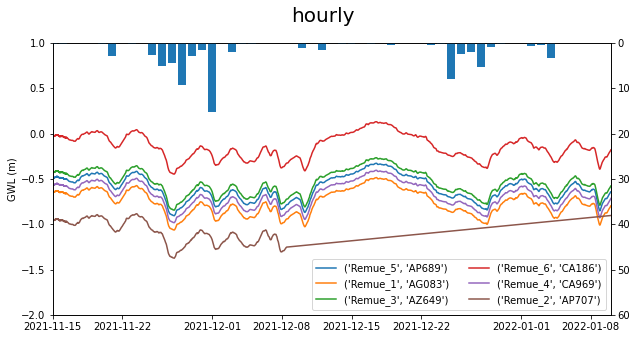

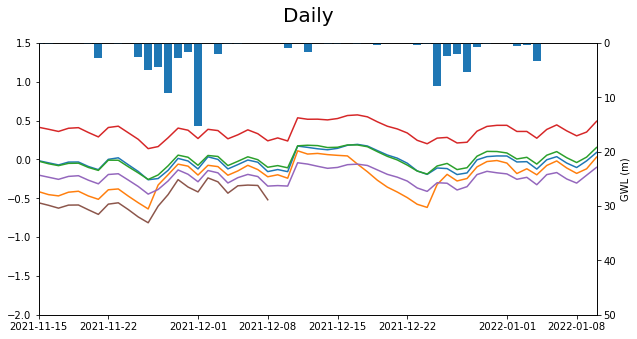

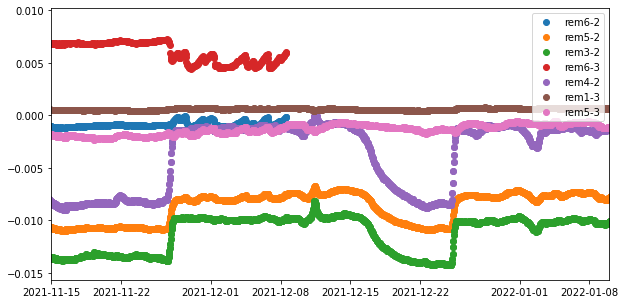

In [20]:
date1=datetime.date(2021,11,15)
date2=datetime.date(2022,1,10)

clim=pd.read_csv('climdata.csv',sep=',', parse_dates=[['date','time']])
#df=df.assign(Date=df.TimeStamp.dt.round('H'))
clim['date_time']=pd.to_datetime(clim['date_time'])
climdaily=clim.resample('D', on = 'date_time').sum()

wellinfo = { 'SerialNumber' : ['AP689','AG083','AZ649','CA186','CA969','AP707'], 
        'WellName' : {'Remue_1','Remue_2','Remue_3','Remue_4','Remue_5','Remue_6'},
        'soil_mTAW' : [14.34, 13.53, 14.75, 13.50, 14.69, 18.15],
        'well_height_m' : [1.13, 1.20, 1.00, 1.15, 1.06, 1.00],
        'initials' : [14.34+1.13-1.67, 13.53+1.20-1.9, 14.75+1.00-1.48, 13.50+1.15-1.23, 14.69+1.06-1.68, 18.15+1.00-2.01]}

baro_data=GWdata[GWdata.SerialNumber == 'AP825']
#import csv

dataall={}
baro_press_int={}  #interpolated barometric pressure head for the timestamps of each piezometer 
#baro_time_int={}  #time stamps barometric pressure head for the timestamps of each piezometer 
WaterPressure={}   #pressure heads recorded by divers for 6 piezometers
HydHead={}         #hydrauli head of each piezo
GWL={}             #groundwater level of each piezo
sumrows={}
piezo_P={}
#difw={}
GWLdaily={}
interp="baro_data" #or "baro_data" or "piezo_data" if it is interpolated based on baro time vector they all have the same t axis else each piezo has its own t axis
fig,  ax = plt.subplots(figsize=(10,5))
fig2, ax2= plt.subplots(figsize=(10,5))

for f,i in enumerate(wellinfo['SerialNumber']):
    #print(i)
    data=GWdata[GWdata.SerialNumber == i].reset_index()
    data = data.sort_values(by=['TimeStamp'])
    data=data[data['Pressure'] > 1100].reset_index() # to remove outliers ?
    dataall[i]=data
    data.to_csv(i+'.csv')
    baro_press_int[i]=pd.Series(np.interp(data.TimeStamp,baro_data.TimeStamp,baro_data.Pressure))#interpolation based on each piezo time vector
    piezo_P[i]=pd.Series(np.interp(baro_data.TimeStamp,data.TimeStamp,data.Pressure)) #interpolation based on barometric time vector
    if interp=="piezo_data":
        WaterPressure[i]=piezo_P[i]#-baro_press_int[i]
        taxis=baro_data.TimeStamp
    elif interp=="baro_data":
        WaterPressure[i]=baro_press_int[i]#-baro_press_int[i]
        taxis=data.TimeStamp
        
    ##here if correct by barometric results of GW will change
    deltawaterpres=(np.diff(WaterPressure[i].array)/100)
    deltawaterpres[0]=wellinfo['initials'][f]+deltawaterpres[0]
    #difw[i]=deltawaterpres
    #diffwat=wellinfo['initials'][f]+np.append(deltawaterpres[0],deltawaterpres[0:-1]+deltawaterpres[1:])
    diffwat=(deltawaterpres.cumsum())
    HydHead[i]=np.append(wellinfo['initials'][f],diffwat)
    GWdepths=wellinfo['soil_mTAW'][f]-HydHead[i]
    GWL[i]=GWdepths

    ##daily data
    data['TimeStamp']=pd.to_datetime(data['TimeStamp'])
    datadaily=data.resample('D', on = 'TimeStamp').mean()
    delPdaily=(np.diff(datadaily.Pressure.array)/100)
    delPdaily[0]=wellinfo['initials'][f]+delPdaily[0]
    difPdaily=(delPdaily.cumsum())
    HyHeaddaily=np.append(wellinfo['initials'][f],difPdaily)
    GWdepdaily=wellinfo['soil_mTAW'][f]-HyHeaddaily
    GWLdaily[i]=GWdepdaily
    
    
    ##plot hourly ax, daily ax
    data_obs=df_info[df_info.SerialNumber == i].reset_index()
    ax.plot(taxis,-GWdepths)
    ax2.plot(datadaily.index.values,-GWdepdaily)
    #ax.scatter(data_obs[data_obs.Time.notnull()].iloc[:,2],-data_obs[data_obs.Time.notnull()].iloc[:,4]/100,s=80)
    #plt.ylim(-1.5,0)
ax.set_ylim([-2,1.])
#plt.title("hourly")
ax.set_ylabel('GWL (m)')
fig.suptitle('hourly', fontsize=20)
ax.legend(list(zip(wellinfo['WellName'],wellinfo['SerialNumber'])),loc='lower right',ncol=2)
axb=ax.twinx()
axb.bar(climdaily.index.values,climdaily.precipitation)
ax.set_xlim([date1,date2])

axb.set_ylim([0, 60])
axb.invert_yaxis()

axc=ax2.twinx()
axc.bar(climdaily.index.values,climdaily.precipitation)

axc.set_ylim([0, 50])
axc.invert_yaxis()
ax2.set_ylim([-2,1.5])
ax2.set_xlim([date1,date2])

axc.set_ylabel('GWL (m)')
fig2.suptitle('Daily', fontsize=20)
gradients={}

pairs=['rem6-2','rem5-2','rem3-2','rem6-3','rem4-2','rem1-3','rem5-3']
dist=[183.7,103,71.4,112.3,49.4,338.8,71.7]
fig, ax3 = plt.subplots(figsize=(10,5))


for j,k in enumerate(pairs):
    print(k)
    #print(j)
    print(wellinfo['SerialNumber'][pd.to_numeric(pairs[j][3])-1],'-',wellinfo['SerialNumber'][pd.to_numeric(pairs[j][5])-1],'/',dist[j])
    p1=pd.to_numeric(pairs[j][5])-1
    p2=pd.to_numeric(pairs[j][3])-1
    gradients[k]=(pd.Series(np.interp(dataall[wellinfo['SerialNumber'][p2]].TimeStamp,dataall[wellinfo['SerialNumber'][p1]].TimeStamp,dataall[wellinfo['SerialNumber'][p1]].Pressure))-dataall[wellinfo['SerialNumber'][p2]].Pressure)/dist[j]/100
    ax3.scatter(dataall[wellinfo['SerialNumber'][p2]].TimeStamp,gradients[k])
ax3.set_xlim([date1,date2])

ax3.legend(pairs,loc='upper right')




In [ ]:
'''
for i in SerialNumbers:
    dfx=pd.DataFrame(GWdata_dic[i],columns =['TimeStamp', 'Pressure'])
    x=dfx.groupby(["Date"]).mean()
    dfy=pd.DataFrame(GWdata_dic['AP825'],columns =['TimeStamp', 'Pressure'])
    y=dfy.groupby(["Date"]).mean()
    diff_data[i]=get_diff(x,y)
    plt.plot((get_diff(x,y))['Date'],(get_diff(x,y))['diff'])
diff_data    
'''
#SerialNumbers=['AP689','AG083','AZ649','CA186','CA969','AP707'] 
#GWdata.groupby('SerialNumber').size()

### Plot raw data for visual check

In [ ]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(30,7), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.

    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    #xtick_locator = DayLocator(interval=1)
    #xtick_dateformatter = DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='.')
    #ax.xaxis.set_major_locator(xtick_locator)
    #ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(df[value_name].min(), df[value_name].max())
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

In [ ]:
# Do the actual plotting using the abovedefined function
#dfdsf
plot_gb_time_series(GWdata, 'TimeStamp', 'SerialNumber', 'Pressure',
                    figsize=(10, 5), title="raw groundwater data REMUE parcels ILVO")

In [ ]:
GWdata.SerialNumber.unique()[:]

In [ ]:
###TO DO 
###df_info contains the hand-measured water depths. 
###They have to be corrected for the well height and can then be used to compare to the logged data at those timepoints.

## Processing steps

Dataset Processing explanation						
1. Collect total pressure (TP) from divers		 (cmH2O)				
2. Calculate water pressure (WP) = TP - AP		 (cmH2O)		
3. Calculate hydraulic gradient. Take the timestep "t" at which a manual measurement is realized and calculate the hydraulic head						
     - H(t) = TW-WD(t)						
     - H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
																	
With :											
AP= Air Pressure (cmH20)											
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)												
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|  AP707  |   Remue_6   |         18,15        |                 1                |      19,15      |
|   CA969   |   Remue_5   |         14,69        |               1,06               |      15,75      |
|   CA186  |   Remue_4   |         13,5         |               1,15               |      14,65      |
|   AZ649   |   Remue_3   |         14,75        |                 1                |      15,75      |
|   AG083  |   Remue_2   |         13,53        |                1,2               |      14,73      |
|   AP689   |   Remue_1   |         14,34        |               1,13               |      15,47      |

In [ ]:
# To DO
Dict = { 'SerialNumber' : {'AP689','AG083','AZ649','CA186','CA969','AP707'}, 
        'WellName' : {'Remue_1','Remue_2','Remue_3','Remue_4','Remue_5','Remue_6'},
        'soil_mTAW' : [14.34, 13.53, 14.75, 13.50, 14.69, 18.15],
        'well_height_m' : [1.13, 1.20, 1.00, 1.15, 1.06, 1.00]}
print("Dict well info: ")
Dict

In [ ]:
# Interpolate all data on same time vector

### TO DO ###
# Create time vector

# Interpolate all sensor data on same vector
#GWint = 
# Plot both to check

# Remove old time vector and data from workspace

# Initiate new column in dataframe for processed data
#Create new column in dataframe for corrected pressure head
GWint['WP'] = GWdata.apply(lambda x: 0, axis=1)    

In [ ]:
for w in Dict['SerialNumber']:
    index = (GWint['SerialNumber'] == w) # find each individual logger in interpolated dataset
    air = (GWint['SerialNumber'] == 'AP825') # find air pressure values in interpolated dataset
    # Calculate water pressure (correct for air pressure)
    GWint['WP'][index] = GWint['Pressure'][index]- GWint['Pressure'][air]
    # Calculate hydraulic gradient
    ### TO DO
    
# Remove air pressure data from interpolated dataframe
### TO DO ###

In [ ]:
# Plot processed values of all loggers
